# INCEPTIONV3

In [1]:
import os
import cv2
import json
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [2]:
input_shape = (128, 128, 3)
data_dir = 'dataset'

real_data = [f for f in os.listdir(data_dir+'/real') if f.endswith('.png')]
fake_data = [f for f in os.listdir(data_dir+'/fake') if f.endswith('.png')]

X = []
Y = []

for img in real_data:
    X.append(img_to_array(load_img(data_dir+'/real/'+img)).flatten() / 255.0)
    Y.append(1)
for img in fake_data:
    X.append(img_to_array(load_img(data_dir+'/fake/'+img)).flatten() / 255.0)
    Y.append(0)

Y_val_org = Y

#Normalization
X = np.array(X)
Y = to_categorical(Y, 2)

#Reshape
X = X.reshape(-1, 128, 128, 3)

#Train-Test split
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

In [3]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import InputLayer
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

googleNet_model = InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape)
googleNet_model.trainable = True
model = Sequential()
model.add(googleNet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(units=2, activation='softmax'))
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
              metrics=['accuracy'])
model.summary()

87910968/87910968 [==============================] - 13s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2, 2, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 2)                 4098      
                                                                 
Total params: 21,806,882
Trainable params: 21,772,450
Non-trainable params: 34,432
_________________________________________________________________


In [4]:
early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=0,
                               patience=2,
                               verbose=0, mode='auto')
EPOCHS = 20
BATCH_SIZE = 100
history = model.fit(X_train, Y_train, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_data = (X_val, Y_val), verbose = 1)

Epoch 1/20
12/12 [==============================] - 96s 7s/step - loss: 0.7296 - accuracy: 0.5205 - val_loss: 0.8678 - val_accuracy: 0.4750
Epoch 2/20
12/12 [==============================] - 82s 7s/step - loss: 0.6465 - accuracy: 0.6321 - val_loss: 0.8387 - val_accuracy: 0.4607
Epoch 3/20
12/12 [==============================] - 84s 7s/step - loss: 0.5827 - accuracy: 0.7196 - val_loss: 0.8401 - val_accuracy: 0.4714
Epoch 4/20
12/12 [==============================] - 83s 7s/step - loss: 0.5259 - accuracy: 0.8071 - val_loss: 0.8501 - val_accuracy: 0.4893
Epoch 5/20
12/12 [==============================] - 79s 7s/step - loss: 0.4779 - accuracy: 0.8696 - val_loss: 0.8493 - val_accuracy: 0.5036
Epoch 6/20
12/12 [==============================] - 81s 7s/step - loss: 0.4210 - accuracy: 0.9170 - val_loss: 0.8507 - val_accuracy: 0.5536
Epoch 7/20
12/12 [==============================] - 84s 7s/step - loss: 0.3708 - accuracy: 0.9384 - val_loss: 0.8690 - val_accuracy: 0.5321
Epoch 8/20
12/12 [==

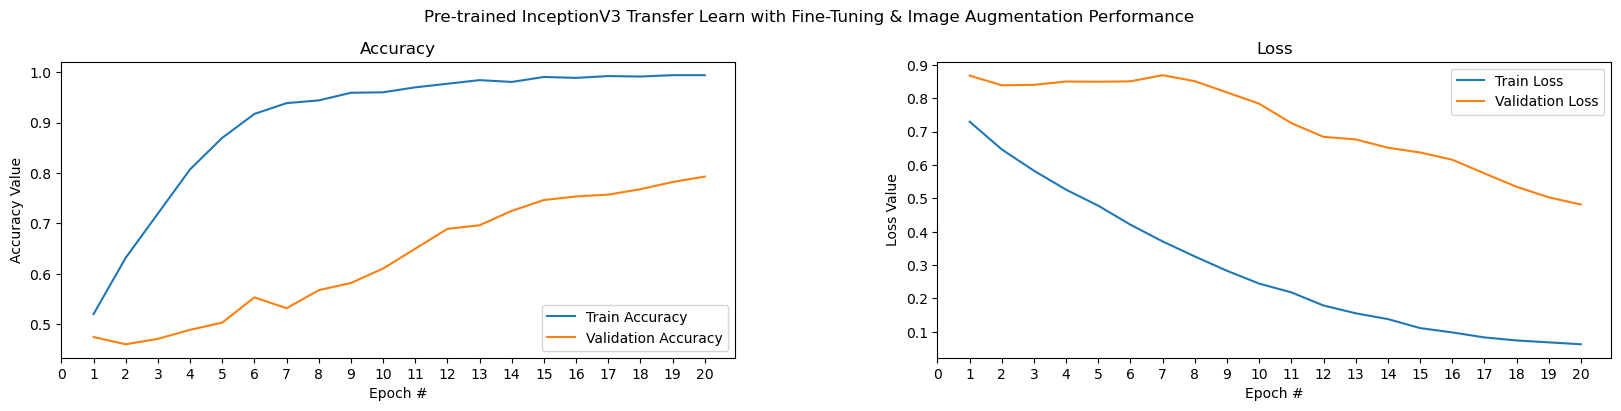

In [5]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Pre-trained InceptionV3 Transfer Learn with Fine-Tuning & Image Augmentation Performance ', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

44/44 [==============================] - 22s 426ms/step
True positive =  592
False positive =  108
False negative =  25
True negative =  675




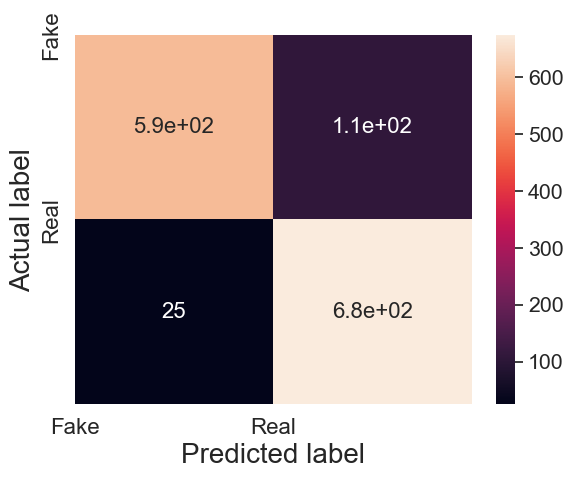

In [6]:
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    
predict_x=model.predict(X) 
classes_x=np.argmax(predict_x,axis=1)

print_confusion_matrix(Y_val_org, classes_x)

In [7]:
model.save('deepfake-detection-model-inception.h5')